In [125]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [126]:
def sampling(args):
    z_mean,var_log = args
    batch=K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    epsilon=K.random_normal(shape=(batch,dim))
    return z_mean+K.exp(0.5*var_log)*epsilon

In [127]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

(28, 28)


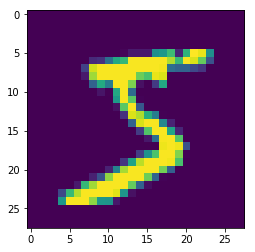

In [128]:
x_train_sample=x_train[0]
print(x_train_sample.shape)
#plt.imshow(x_train_sample, cmap='gray')
plt.imshow(x_train_sample)

In [129]:
imag_size=x_train.shape[1]
x_train=np.reshape(x_train,[-1,imag_size*imag_size])
x_test=np.reshape(x_test,[-1,imag_size*imag_size])
x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255

In [130]:
imag_dim0=imag_size*imag_size
input_shape=(imag_dim0,)
dim_latent=2
epochs=10
dim1=128
batch_size=64

In [131]:
inputs=Input(shape=input_shape,name='encoder_input')
x=Dense(dim1,activation='relu')(inputs)
z_mean=Dense(dim_latent,name='z_mean')(x)
z_log_var=Dense(dim_latent,name='z_log_var')(x)
z=Lambda(sampling,output_shape=(dim_latent,),name='layer_z')([z_mean,z_log_var])

In [132]:
print(z.shape)

(?, 2)


In [133]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 128)          100480      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            258         dense_13[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            258         dense_13[0][0]                   
__________________________________________________________________________________________________
layer_z (L

In [134]:
inputs_latent=Input(shape=(dim_latent,),name='z_sample')
x=Dense(dim1,activation='relu')(inputs_latent)
outputs=Dense(imag_dim0,activation='sigmoid')(x)


In [135]:
decoder=Model(inputs_latent,outputs,name='decoder')
decoder.summary()
plot_model(decoder,to_file='vae_mlp_decoder.png',show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sample (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_15 (Dense)             (None, 784)               101136    
Total params: 101,520
Trainable params: 101,520
Non-trainable params: 0
_________________________________________________________________


In [136]:
outputs=decoder(encoder(inputs)[2])
vae=Model(inputs,outputs,name='vae')

In [137]:
print(outputs.shape)

(?, 784)


In [138]:
def vae_loss(x,y):
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    loss = K.mean(reconstruction_loss + kl_loss)
    return loss

In [139]:
models=(encoder,decoder)
#data=(x_test,y_test)
vae.compile(optimizer='adam',loss=vae_loss)


In [140]:
vae.fit(x_train, x_train,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(x_test, x_test))     


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 146us/step - loss: 0.2971 - val_loss: 0.2635
Epoch 2/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.2634 - val_loss: 0.2628
Epoch 3/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 4/10
60000/60000 [==============================] - 8s 137us/step - loss: 0.2631 - val_loss: 0.2628
Epoch 5/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2631 - val_loss: 0.2629
Epoch 6/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 7/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 8/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.2630 - val_loss: 0.2628
Epoch 9/10
60000/60000 [==============================] - 9s 144us/step - loss: 0.2630 - val_loss: 0.2

In [148]:
vae.save_weights('vae_mnist.h5')

In [141]:
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)
#vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,None))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 100996    
_________________________________________________________________
decoder (Model)              (None, 784)               101520    
Total params: 202,516
Trainable params: 202,516
Non-trainable params: 0
_________________________________________________________________


In [142]:
def plot_figure(models,data,batch_size=32,model_name='vae_mnist'):
    encoder,decoder=models
    x_test,y_test=data
    os.makedirs(model_name,exist_ok=True)
    filename=os.path.join(model_name,'vae_mean.png')
    z_mean,_,_=encoder.predict(x_test,batch_size=batch_size)
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:,0],z_mean[:,1],c=y_test)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.savefig(filename)
    plt.show()
    filename=os.path.join(model_name,"digits_over_latent.png")
    n=20
    digit_size=28
    figure=np.zeros((digit_size*n,digit_size*n))
    grid_x=np.linspace(-4,4,n)
    grid_y=np.linspace(-4,4,n)[:,:,-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [143]:
#plot_figure(models,data,batch_size=batch_size,model_name="vae_mlp")

In [144]:
nsample=100
step=20
x_test_sample=x_test[range(0,step*nsample,step),:]
print(x_test_sample.shape)
x_test_sample=x_test_sample.reshape(-1,784)
outputs=vae.predict(x_test_sample,batch_size)

(100, 784)


(100, 28, 28)


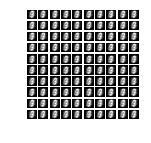

In [145]:
outputs=np.reshape(outputs,[-1,28,28])
print(outputs.shape)

nrow=10
ncol=10
plt.figure(figsize=(2,2))
for i in range(outputs.shape[0]):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(outputs[i],cmap='gray')
    plt.axis('off')


In [146]:
out_encoder=encoder.predict(x_test_sample,batch_size)

In [147]:
print(out_encoder[0])
print(out_encoder[1])
print(out_encoder[2])
#np.reshape(out_encoder[0],[imag_size,imag_size])

[[-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-1.36786920e-03 -7.75014982e-03]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [ 4.93212356e-05 -1.15303497e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [ 7.25769321e-04 -1.96121144e-03]
 [ 1.10470748e-03 -2.56418157e-03]
 [ 6.79767036e-05 -1.66211015e-04]
 [ 3.72459908e-04 -9.97092109e-04]
 [ 7.35479407e-04 -1.98770850e-03]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2.59368913e-04]
 [-8.79805375e-05  2